In [255]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import random

#import mpld3
#mpld3.enable_notebook()


## Define a few building blocks for generating our input data

In [256]:
def constant(v, count = 100):
    return [v] * count

def jitter(v, amplitude):
    return [y + random.randint(0, amplitude) - amplitude * 0.5 for y in v]

def increasing(from_, to_, count = 100):
    return list(np.arange(from_, to_, (to_ - from_) / count))

def sin(base, amplitude, count = 100):
    return [base + amplitude * float(np.sin(2.0 * np.pi * t / count)) for t in range(count)]

### And a method for plotting and evaluating target algorithms

Note that it supports two algorithms. One `ref` (reference) and one that is the "algorithm-under-test" (`test`). This allows you to compare and benchmark one algorithm with another.

In [257]:
def run_algorithm(algorithm, data):
    if algorithm is None:
        return []
    # If the algorithm returns an array, it's an "online" algorithm and can work in a streaming way
    # providing 
    result = algorithm(data)
    if isinstance(result, list):
        return result
    
    # It's not. We have to call it with the data one sample at a time.
    result = []
    ts = []
    for i in range(len(data)):
        ts.append(data[i])
        result.append(algorithm(ts))
    return result

def evaluate(data, ref, test):
    fig, ax = plt.subplots()
    ax.plot(data, color="green", alpha=0.4)

    tests = run_algorithm(test, data)
    refs = run_algorithm(ref, data)
            
    ax.plot(refs, color="red", ls='-.', label="ref")
    ax.plot(tests, color="blue", ls=':', label="test")
    ax.legend()
        
    over = [i for i in range(len(data)) if data[i] > tests[i - 1]]
    print(over)

### This is our proposed algorithm

In [258]:
def unDef(a):
    if math.isnan(a):
        return True
    if math.isinf(a):
        return True
    return False


def ewma(series, com):
    """Exponentially weighted moving average, as found in pandas"""
    series = [1.0 * s for s in series]
    com = 1.0 * com
    N = len(series)
    ret = [0.0] * N
    if N == 0:
        return ret
    oldw = com / (1 + com)
    adj = oldw
    ret[0] = series[0] / (1 + com)
    for i in range(1, N):
        cur = series[i]
        prev = ret[i - 1]
        if unDef(cur):
            ret[i] = prev
        else:
            if unDef(prev):
                ret[i] = cur / (1 + com)
            else:
                ret[i] = (com * prev + cur) / (1 + com)

    for i in range(N):
        cur = ret[i]
        if not math.isnan(cur):
            ret[i] = ret[i] / (1.0 - adj)
            adj *= oldw
        else:
            if i > 0:
                ret[i] = ret[i - 1]
    return ret

def ewmstd_last(series, com):
    """Exponentially weighted moving standard deviation, last element"""
    m1st = ewma(series, com)
    m2nd = ewma([v*v for v in series], com)

    last = len(m1st) - 1
    t = m2nd[last] - m1st[last] * m1st[last]
    t *= (1.0 + 2.0 * com) / (2.0 * com)
    if t < 0:
        return 0
    return math.sqrt(t)

def algo_ewma_std(timeseries, factor=3):
    ts = timeseries[-20:]
    median = ewma(ts, 10)[-1]
    s = ewmstd_last(ts, 10)
    try:
        return (int)(factor * s + median + 1000)
    except ValueError:
        return 0
    
def reject_outliers(data, m=2):
    u = np.mean(data)
    s = np.std(data)
    filtered = [e for e in data if (u - m * s < e < u + m * s)]
    return filtered
    
def algo_ewma_std_reject_outliers(timeseries, factor=3):
    ts = timeseries[-20:]
    
    ts2 = reject_outliers(ts, 3)
    if ts2:
        ts = ts2
    median = ewma(ts, 10)[-1]
    s = ewmstd_last(ts, 10)
    s2 = np.std(ts)
    try:
        return (int)(factor * s + median + 1000)
    except ValueError:
        return 0
    
ref = algo_ewma_std
test = algo_ewma_std_reject_outliers

### Test input 1

A heartbeat that comes every five to six minutes, throughout the day (changing because of load on the system). It varies a bit - up to 30 seconds between runs even if the load is static.

[2, 3]


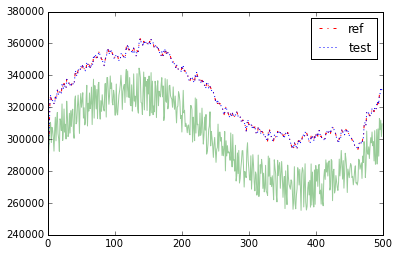

In [259]:
data = jitter(sin(5 * 60000, 30000, count=500), 30000)

evaluate(data, ref, test)


### Test input 2

A constant heartbeat. Very predictive.

[]


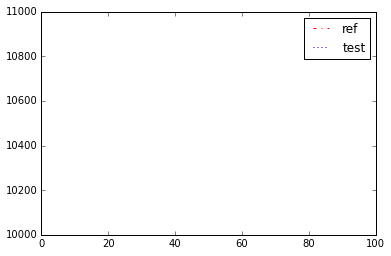

In [260]:
data = constant(10000)

evaluate(data, ref, test)


### A more complex varying load

It also shows how the beat frequency was changed from once a minute to once every two minutes. This should of course be detected.

[103, 300, 301]


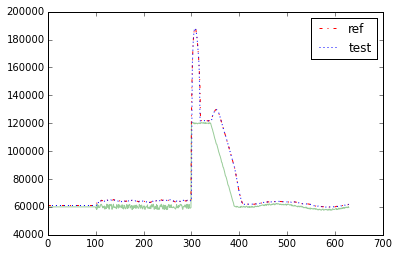

In [261]:
data = jitter(constant(60000, count=50), 0) \
        + jitter(constant(60000, count=50), 0) \
        + jitter(constant(60000, count=200), 4000) \
        + jitter(constant(120000, count=40), 1000) \
        + jitter(increasing(120000, 60000, count=50), 1000) \
        + jitter(constant(60000, count=40), 1000) \
        + jitter(sin(60000, 2000, count=200), 1000)
        
evaluate(data, ref, test)

### An increasingly jittery load

[]


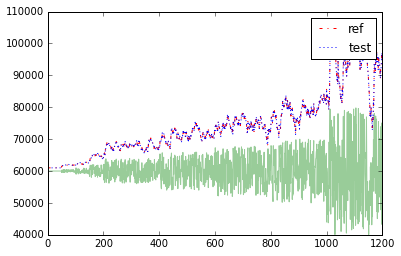

In [262]:
data = jitter(constant(60000, count=50), 0) \
        + jitter(constant(60000, count=50), 1000) \
        + jitter(constant(60000, count=50), 2000) \
        + jitter(constant(60000, count=50), 4000) \
        + jitter(constant(60000, count=200), 8000) \
        + jitter(constant(60000, count=200), 12000) \
        + jitter(constant(60000, count=200), 16000) \
        + jitter(constant(60000, count=200), 20000) \
        + jitter(constant(60000, count=200), 40000)
        
evaluate(data, ref, test)

### Handling a large spike

If a service is down for a while, and goes up again, how well does our algorithm recover?

We can see that the effects from the spike lasts very long. Actually, up to 20 samples (which is the window we're using). This could be further improved.

[50]


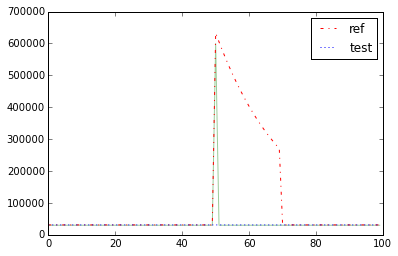

In [263]:
data = jitter(constant(30000, 100), 20)
data[50] = 10 * 60000

evaluate(data, ref, test)

### Handling double beats


[]


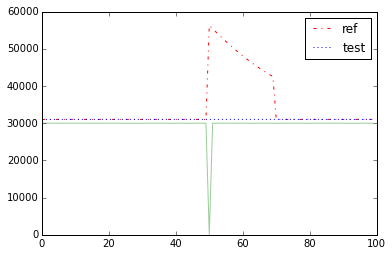

In [264]:
data = jitter(constant(30000, 100), 20)
data[50] = 1

evaluate(data, ref, test)

[29, 30]


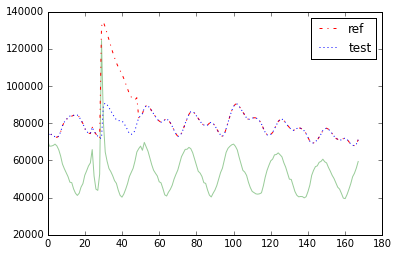

In [265]:
data = [70726.2, 67643.6, 67704.3, 68023.6, 68743.4, 67782, 65726.9, 62416.6, 58031.9, 55566.6, 53365.4, 
        51251.1, 48292.4, 48025.3, 44631.8, 42370.5, 41162.8, 42348.7, 45643.9, 47511.3, 51991.6, 54398.1,
        57022.7, 58653.3, 65816.9, 51578.8, 44560.1, 43882.7, 52602.1, 124490, 80847.1, 64499.1,  59527.6,
        55655.6, 53964.6, 51776.3, 49120.2, 47653.9, 43989.7, 41220.6, 40241.4, 41943.6, 44538.6, 47536.9,
        51360.7, 53624.9, 55779.5, 59666.4, 64510.6, 66311.3, 67667.6, 65440.1, 69684.1, 67364.7, 64902.5, 
        61256.6, 57664.2, 54714.4, 53109.6, 51618.9, 48533.5, 47920.4, 44887.2, 41486.3, 40844.7, 42928.3,
        44422.5, 46622.3, 49935.8, 52484.1, 54765.2, 58326.3, 62001.3, 63918, 65927.1, 65990.6, 66997.1, 
        66293, 64181.4, 60773.9, 57239.3, 54165.6, 53191.3, 51350.9, 48038, 47631.1, 44122.9, 41345.9, 
        40352, 42332.6, 44061.6, 46537.8, 50086.9, 53440.9, 55781, 60158.8, 64306.6, 66479.2, 67567.2,
        68380.5, 68766.3, 67552.7, 65607.8, 61651.6, 58161.6, 54662.9, 53720.1, 51923.5, 48246.2, 45374.6,
        43337.6, 42652.8, 42010.5, 41856.4, 42056.2, 42576.8, 46273.7, 50938.6, 54639.3, 57342.4, 59774.6,
        60706, 62984.4, 63172.7, 64042.6, 63036.4, 61925.8, 58798.6, 56394.9, 53050.7, 49905.7, 49781.8,
        46577.2, 43242.3, 41269.5, 40422.3, 40587.8, 40530.8, 39845, 40492.2, 43246.3, 46699.2, 51971.9,
        54654.5, 56630.8, 57076.9, 58955.2, 59459.6, 60647.5, 59267.8, 58642.9, 56231.5, 54234.9, 51979.6,
        50252.1, 47931.1, 45590.3, 44554.6, 42227.4, 39722.7, 39453.8, 41632, 44427.5, 47465.5, 51199.2,
        53105.7, 55873.8, 59402.5]

evaluate(data, ref, test)

As the algorithm only works on the last samples, depending on how often the spikes occur will affect the filtering.

[10, 15, 20, 50, 75]


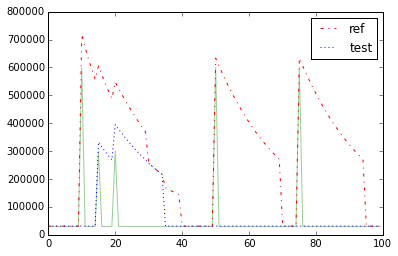

In [266]:
data = jitter(constant(30000, 100), 20)
data[10] = 10 * 60000
data[15] = 5 * 60000
data[20] = 5 * 60000

data[50] = 10 * 60000
data[75] = 10 * 60000


evaluate(data, ref, test)

## Evaluate the actual implementation

Lovebeat provides a mode where you can specify time series data and it will output the result of the "auto algorithm" - perfect for testing and verifying that the implementation (in Go) is identical to the one we have here.

In [267]:
LOVEBEAT_PATH = "~/r/go/src/github.com/boivie/lovebeat/lovebeat"

def goimplementation(data):
    import os
    import subprocess
    args = [os.path.expanduser(LOVEBEAT_PATH), '--validate-auto']
    proc = subprocess.Popen(args,stdout=subprocess.PIPE,
                            stdin=subprocess.PIPE, stderr=subprocess.PIPE)
    result = []
    for value in data:
        proc.stdin.write("%d\n" % value)
        result.append(int(proc.stdout.readline()))
    proc.stdin.write("\n")
    proc.stdin.close()
    proc.wait()
    return result



[10, 15, 20, 50, 75]


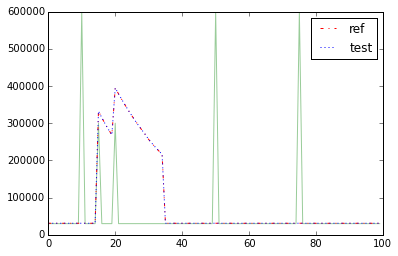

In [268]:
# NOTE: our 'ref' is actual our 'test' - the one we're benchmarking against!

evaluate(data, test, goimplementation)